# Importing libraries and loading the data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from  tensorflow.keras import optimizers
#from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/training_data.zip
!unzip /content/gdrive/MyDrive/test_data.zip

# Preparing the data

In [ ]:
data_generator = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip = True,
        validation_split = 0.2)

data_test_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_data = '/content/training_data'
test_data = '/content/test_data'

img_height = 100
img_width = 100
batch_size = 16

train_ds = data_generator.flow_from_directory(
    training_data,
    color_mode='rgb',
    class_mode = "binary",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    subset = "training"
)

val_ds = data_generator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
    subset = "validation"
)

test_ds = data_test_generator.flow_from_directory(
    test_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode='rgb',
    class_mode = "binary",
)

Found 2176 images belonging to 2 classes.
Found 542 images belonging to 2 classes.
Found 680 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

[0. 1. 0. 0.]


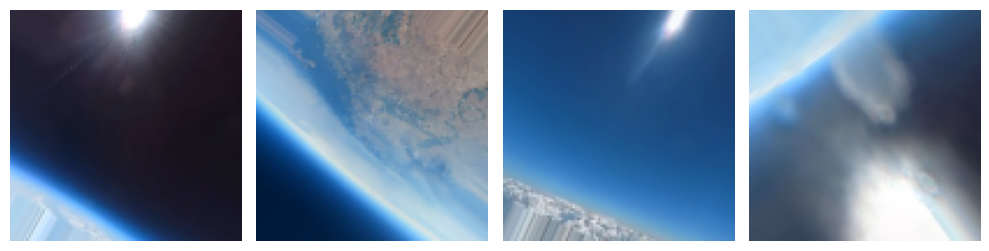

In [ ]:
sample_training_images, labels= next(iter(train_ds))
print(labels[:4])
plotImages(sample_training_images[:4])

# Model definition

In [ ]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Activation(keras.activations.relu))
model_cnn.add(keras.layers.MaxPooling2D((4,4)))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(32,  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.Dense(1, activation = "sigmoid"))

model_cnn.build((None, 100, 100, 3))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 activation (Activation)     (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 64)        0

In [ ]:
#plot_model(model_cnn, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = optimizers.Adam(
    learning_rate=0.00005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)


model_cnn.compile(loss='binary_crossentropy', optimizer =optimizer,
             metrics=['accuracy'])

# Model training

In [ ]:
training_samples = train_ds.n
val_samples = val_ds.n

epochs = 2

history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Epoch 1/2
136/136 [==============================] - 84s 608ms/step - loss: 3.5022 - accuracy: 0.8267 - val_loss: 3.5670 - val_accuracy: 0.8049
Epoch 2/2
136/136 [==============================] - 81s 598ms/step - loss: 3.0702 - accuracy: 0.9297 - val_loss: 3.2332 - val_accuracy: 0.8333


In [ ]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "-", label =" Training accuracy")
  ax[0].plot(nepochs, val_acc, "-", label= "Validation accuracy")
  ax[0].set_title("Training & validation accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "go-", label =" Training Loss")
  ax[1].plot(nepochs, val_loss, "ro-", label= "Validation Loss")
  ax[1].set_title("Training & validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()


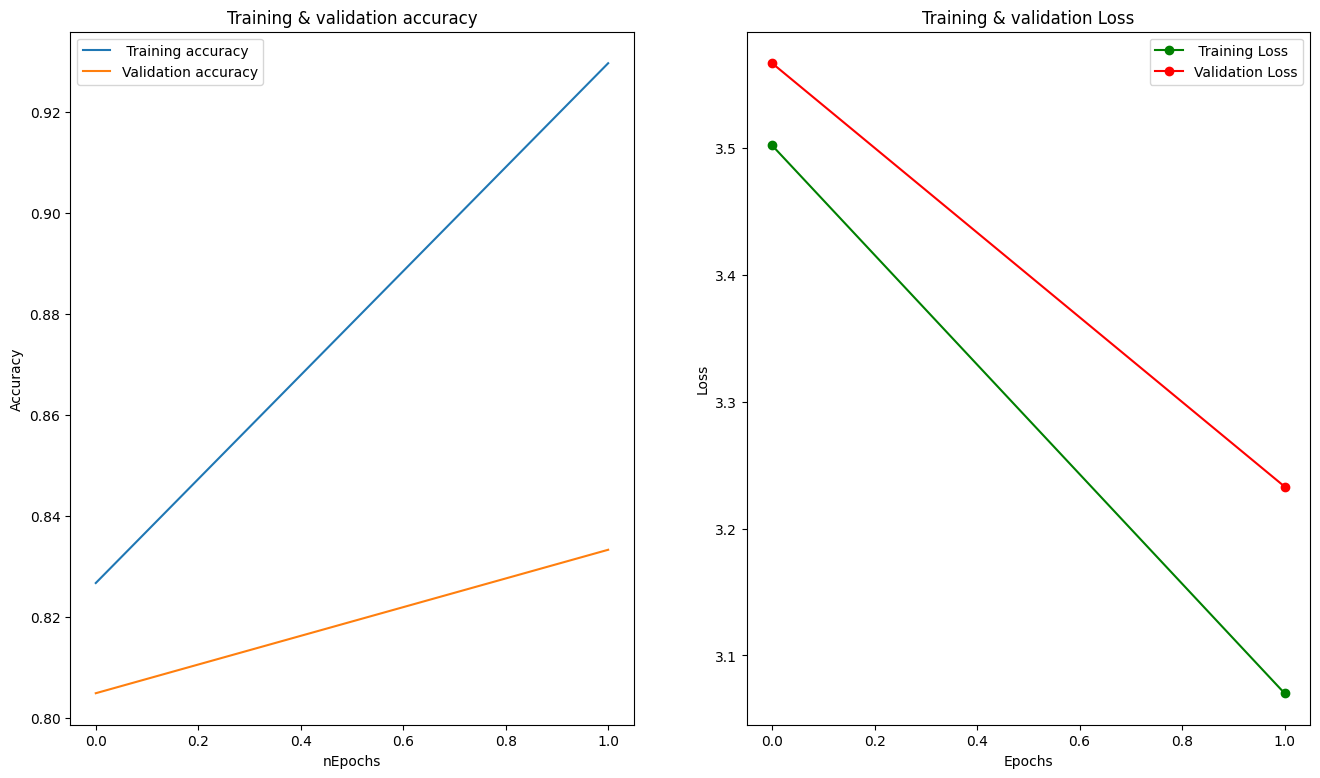

In [ ]:
visualizacion_resultados(history_cnn)

# Tensorflow model evaluation

In [ ]:
loss, accuracy = model_cnn.evaluate(test_ds)

43/43 [==============================] - 14s 321ms/step - loss: 3.1194 - accuracy: 0.9250


In [ ]:
import time
sample_test_images, true_label_id = next(iter(test_ds))

start_time = time.time()
tf_model_predictions = model_cnn(sample_test_images)
end_time = time.time()

time_diff = end_time - start_time
print(f'Processing time: {round(time_diff*1000, 2)} ms')

Processing time: 96.84 ms


In [ ]:
predicted_ids = []

for x in tf_model_predictions.numpy():
  if x > 0.5:
    predicted_ids.append(1)
  else:
    predicted_ids.append(0)

print(predicted_ids)
print(true_label_id)

[0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]
[0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.]


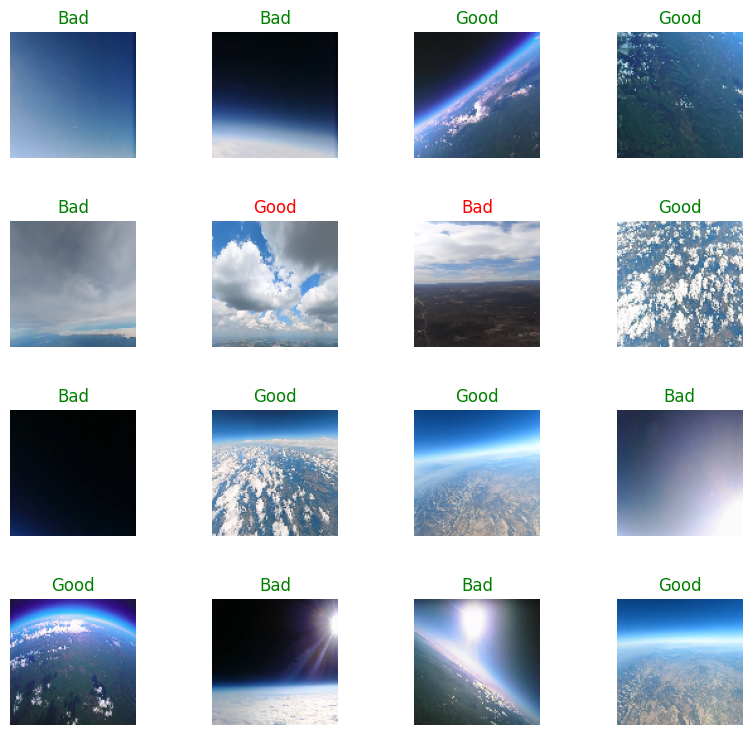

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_test_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  if predicted_ids[n] == 1:
    text = 'Good'
  else:
    text = 'Bad'
  plt.title(text.title(), color=color)
  plt.axis('off')

In [ ]:
!mkdir tf_models

model_cnn.save("tf_models/model_cnn.h5")
print("Tensorflow model size")
!ls "tf_models" -lh

Tensorflow model size
total 3.3M
-rw-r--r-- 1 root root 3.3M Oct 18 17:05 model_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Pruning

In [ ]:
! pip install -q tensorflow-model-optimization

import tensorflow_model_optimization as tfmot

num_images = train_ds.n
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
#threshold_value = 0.1
pruning_params = {
    #'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, 0)
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity = 0.5,
                                                            final_sparsity = 0.8,
                                                            begin_step = 0,
                                                            end_step = end_step)
}

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model_cnn, **pruning_params)

pruned_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

pruned_model.summary()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.4 MB/s eta 0:00:00
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, None, None, 32)    1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_batch_  (None, None, None, 32)    129       
 normalization (PruneLowMag                                      
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_po  (None, None, None, 32)    1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, None

In [ ]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model.fit(train_ds, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

Epoch 1/2
136/136 [==============================] - 93s 649ms/step - loss: 2.6728 - accuracy: 0.8971
Epoch 2/2
136/136 [==============================] - 71s 520ms/step - loss: 1.8858 - accuracy: 0.8194


In [ ]:
pruned_model_loss, pruned_model_accuracy = pruned_model.evaluate(test_ds)

print('Baseline test accuracy:', accuracy)
print('Pruned test accuracy:', pruned_model_accuracy)


43/43 [==============================] - 17s 396ms/step - loss: 1.7585 - accuracy: 0.7088
Baseline test accuracy: 0.925000011920929
Pruned test accuracy: 0.7088235020637512


In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

<ipython-input-23-7902bd1343f9>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: /tmp/tmpzo0ua9ac.h5


In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))


Saved quantized and pruned TFLite model to: /tmp/tmpg21gh_p7.tflite
Size of gzipped pruned and quantized TFlite model: 100526.00 bytes


# **TFLite modedl quantization**

In [ ]:
!mkdir "tflite_quantized_models"
TFLITE_MODEL_QUANTIZED = "tflite_quantized_models/cnn_quantized_final.tflite"

mkdir: cannot create directory ‘tflite_quantized_models’: File exists


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
quantized_and_pruned_tflite_model = converter.convert()


open(TFLITE_MODEL_QUANTIZED, "wb").write(quantized_and_pruned_tflite_model)

print("Tflite model size")
!ls "tflite_quantized_models" -lh


Tflite model size
total 288K
-rw-r--r-- 1 root root 285K Oct 18 17:40 cnn_quantized_final.tflite


In [ ]:
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_MODEL_QUANTIZED)

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (16, 100, 100, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

tflite_interpreter_quant.set_tensor(input_details[0]['index'], sample_test_images)

tflite_interpreter_quant.invoke()
start_time = time.time()
tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
end_time = time.time()

time_diff = end_time - start_time

print("\nPrediction results shape:", tflite_q_model_predictions.shape)
print(f'Processing time: {round(time_diff*1000, 2)} ms')

== Input details ==
name: serving_default_conv2d_input:0
shape: [ 16 100 100   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  5]
type: <class 'numpy.float32'>

Prediction results shape: (16, 1)
Processing time: 0.15 ms


In [ ]:
predicted_ids = []

for x in tflite_q_model_predictions:
  if x > 0.5:
    predicted_ids.append(1)
  else:
    predicted_ids.append(0)

print(predicted_ids)
print(true_label_id)

[1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
[0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.]


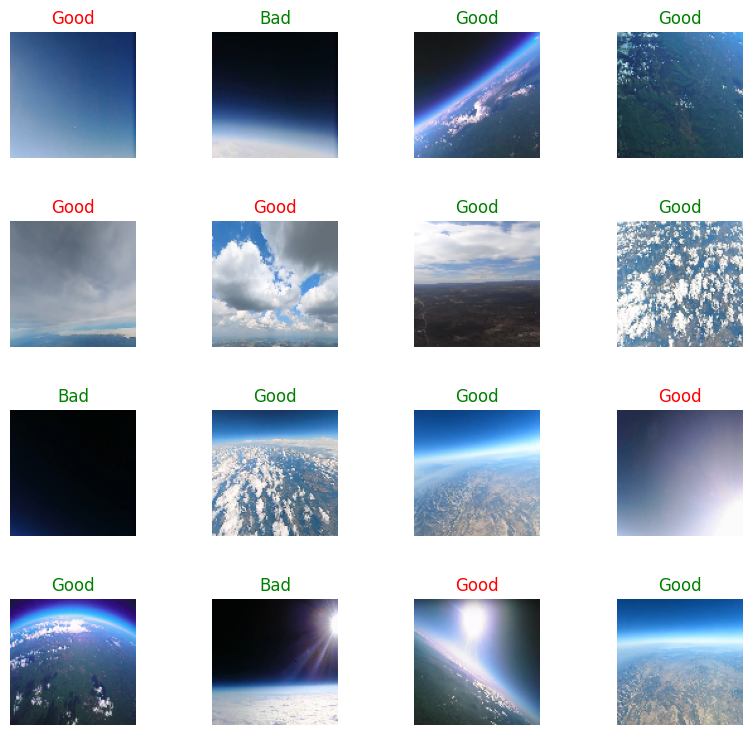

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(sample_test_images[n])
  color = "green" if predicted_ids[n] == true_label_id[n] else "red"
  if predicted_ids[n] == 1:
    text = 'Good'
  else:
    text = 'Bad'
  plt.title(text.title(), color=color)
  plt.axis('off')